# Interacting with CLIP

CLIP is a big model which is has really made some waves in the ML world, but it's original purpose is actually quite simple. CLIP stands for __C__ontrastive __L__anguage-__I__mage __P__re-training. The model was trained on image-caption pairs, where the caption is describing what is in the image. And the dataset it was trained on was __big__. The _contrastive_ aspect on the name was the clever contribution this model made to research in that it reduces both the image and the caption down to an abstract mathmatical representation, both of which can be _compared_ - in mathmatical terms. So the model will output a probability of how likely a caption goes with a given image.

CLIP performs very well under "zero-shot" conditions. You will see this term a lot, and all it means is _the ability for a model to classify a data point belonging to a __class__ not seen in training._ This is impressive as a dataset can only contain a certain amount of _classes_, so if a model can _infer_ some extra information from the dataset and still perform well even on __unknown classes__, let alone new images, then that's some good stuff.

This is quite a breif notebook from the official [CLIP repository](https://github.com/openai/CLIP) when you can do some basic playing around with CLIP. At the end I've added some cells to upload your own image.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip3 install torch==1.8.2+cu102 torchvision==0.9.2+cu102 torchaudio==0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yjjv_9qr
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-yjjv_9qr
Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html


In [1]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.8.2+cu102


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 188MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f5884931290>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

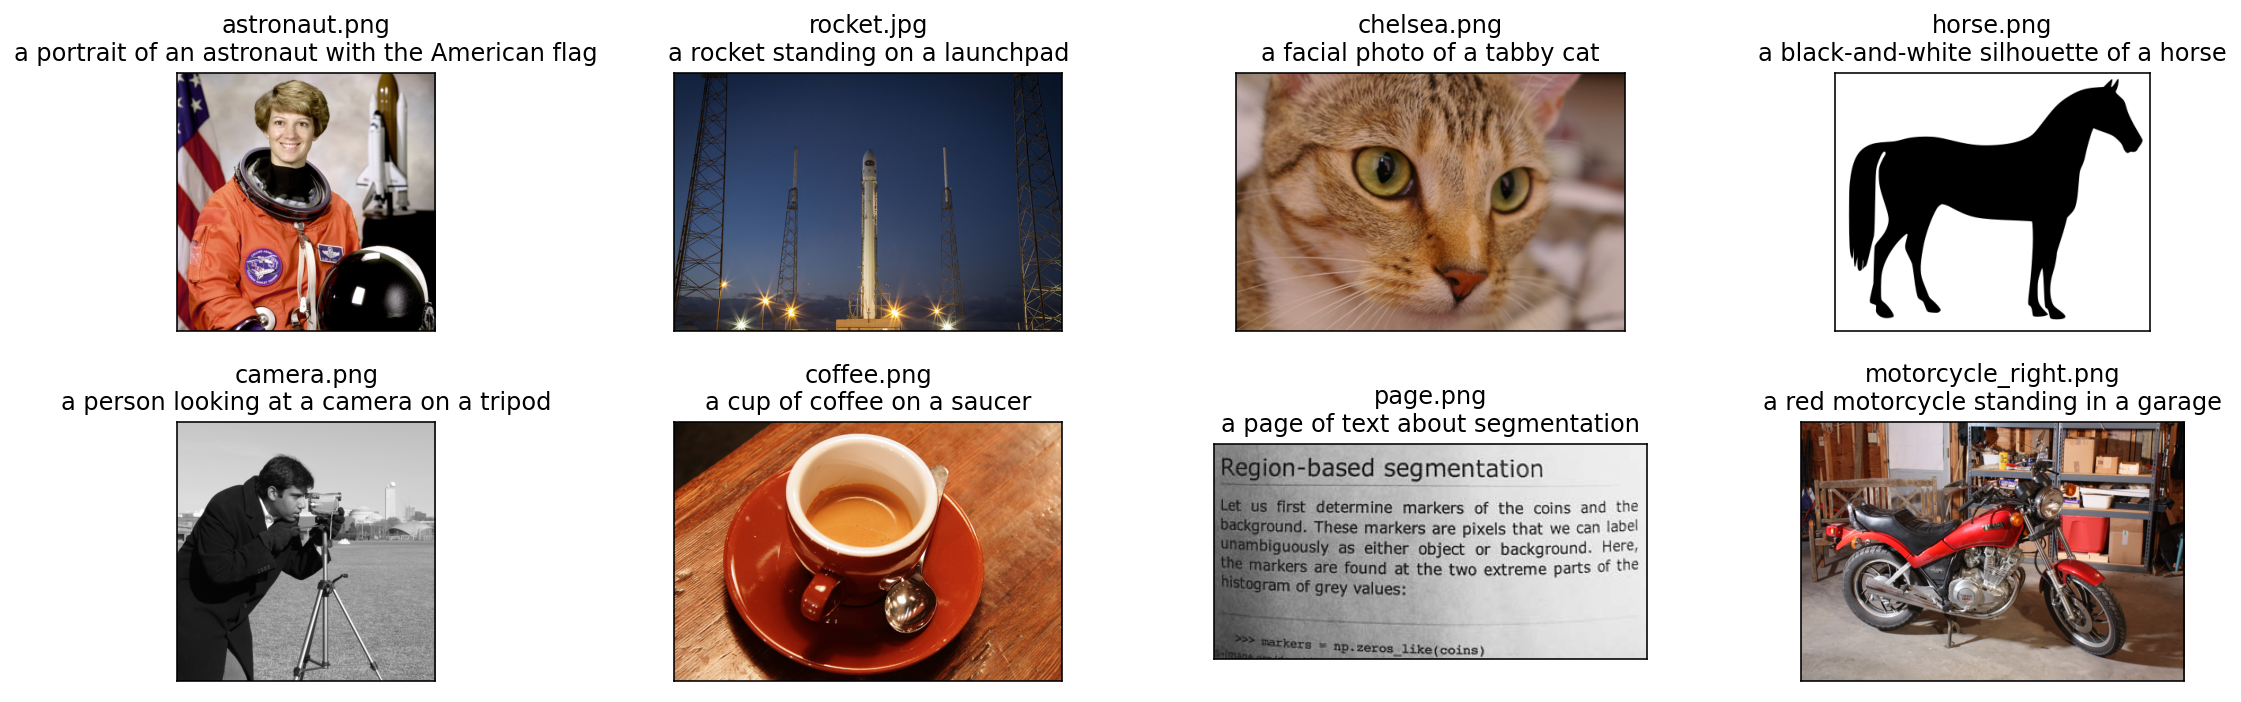

In [8]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [9]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [10]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [11]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

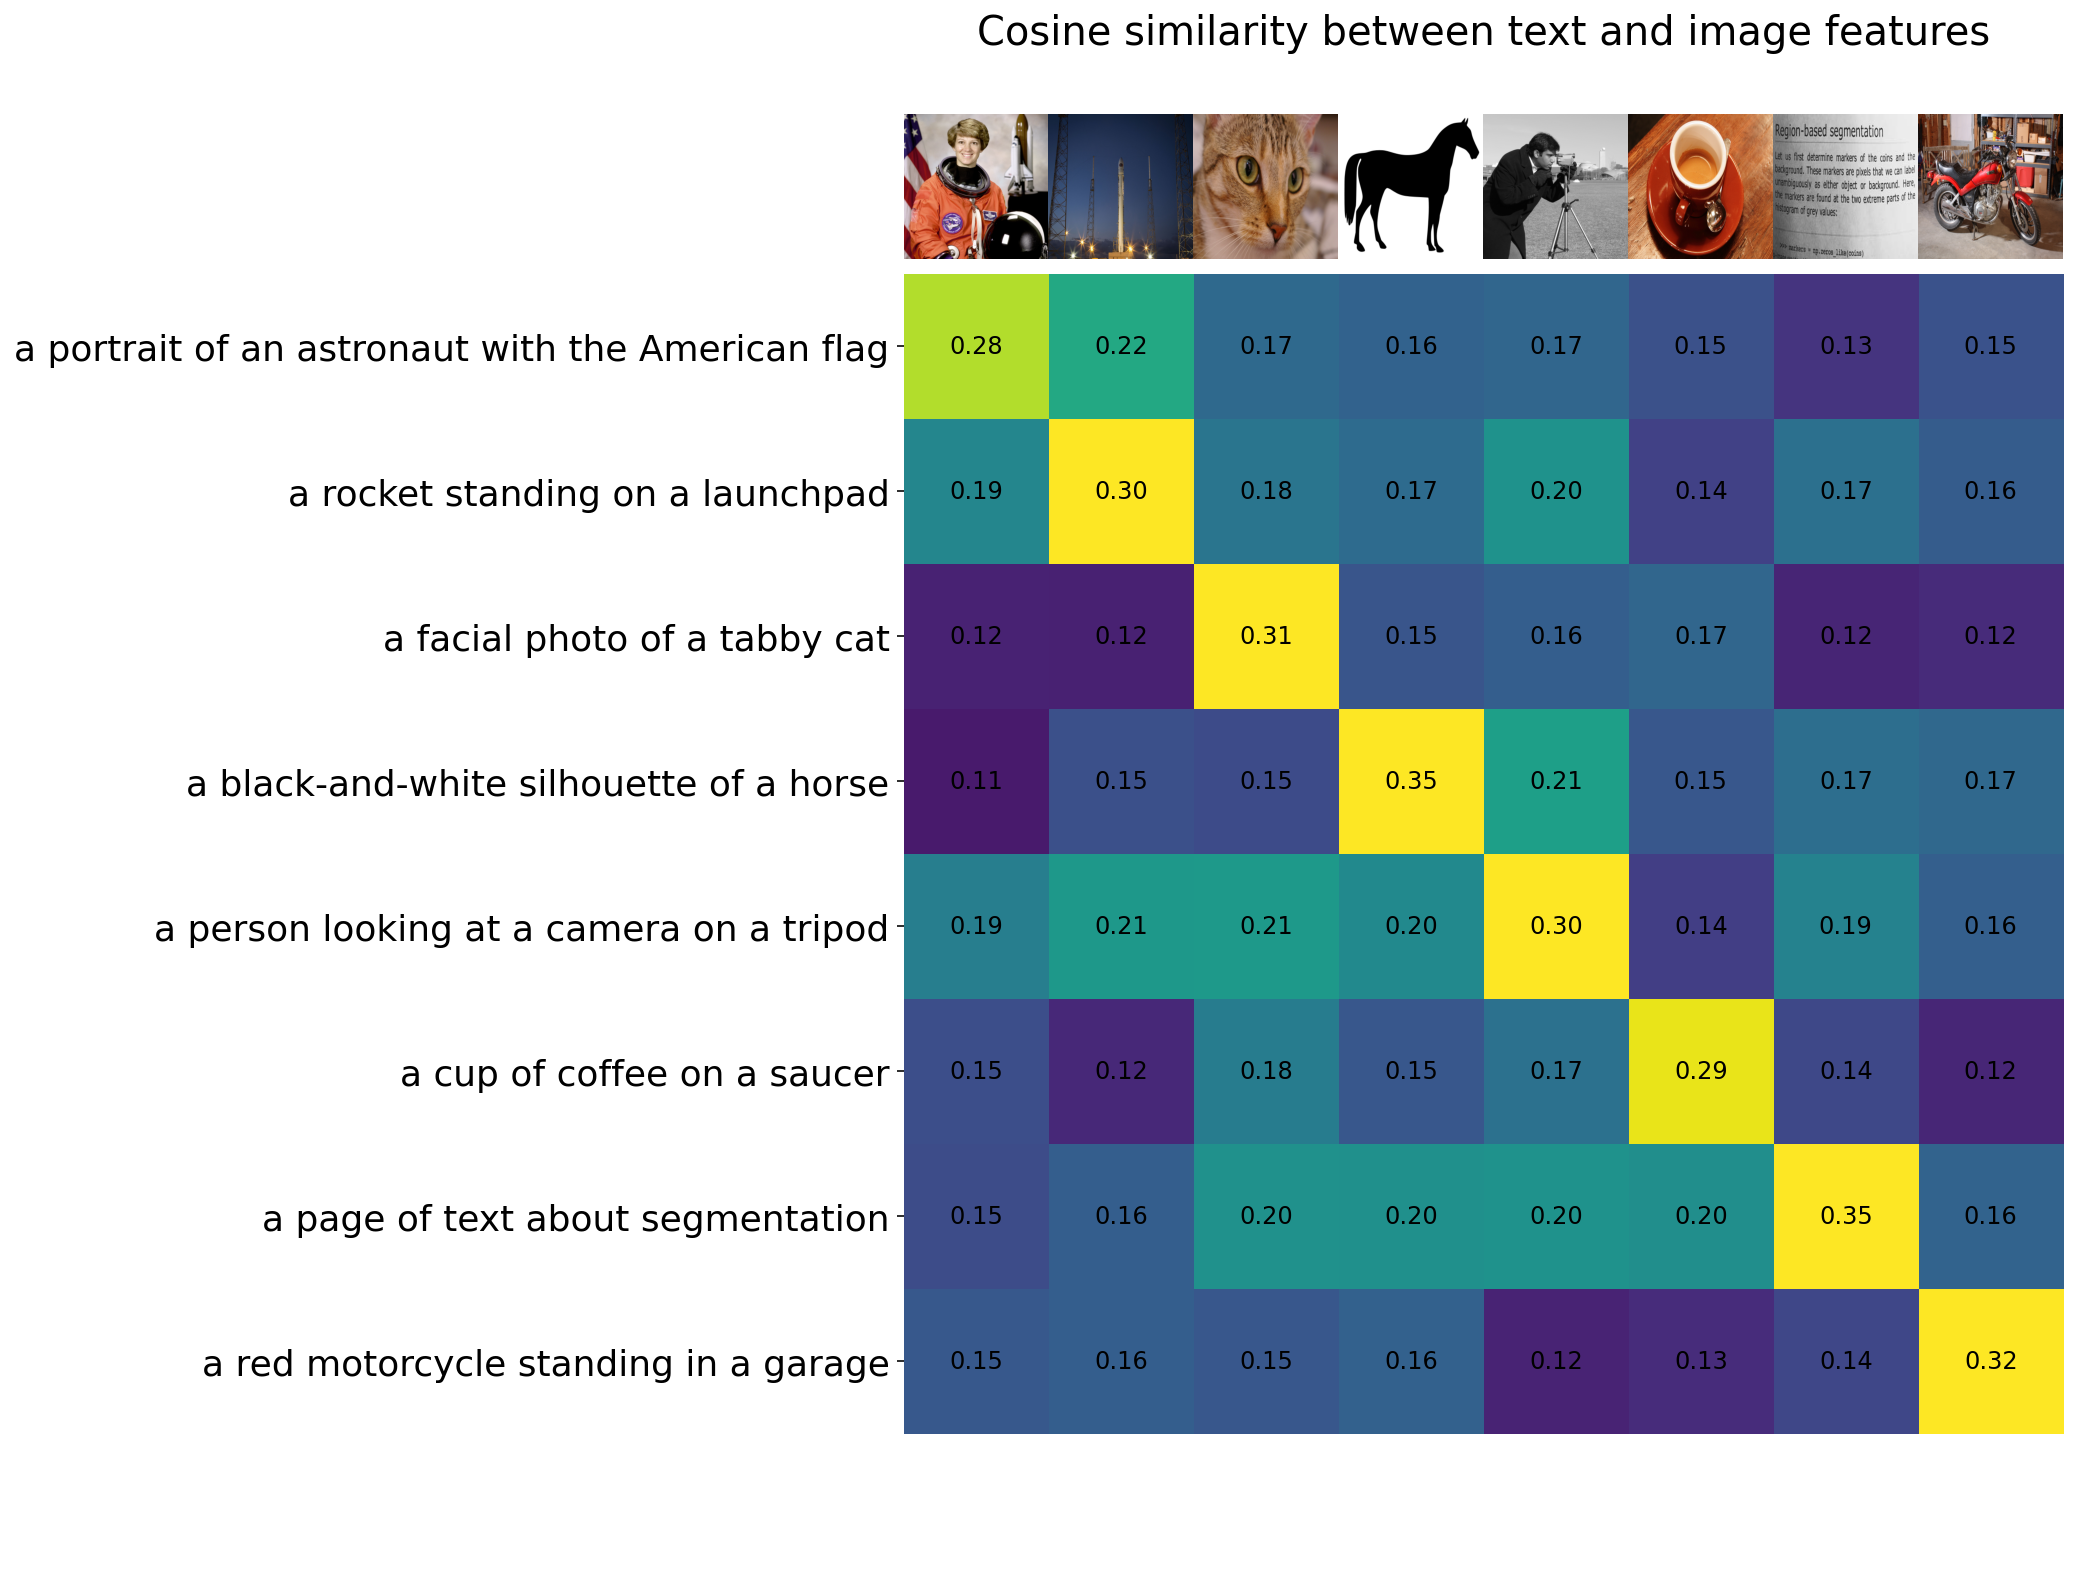

In [12]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [13]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [14]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [15]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

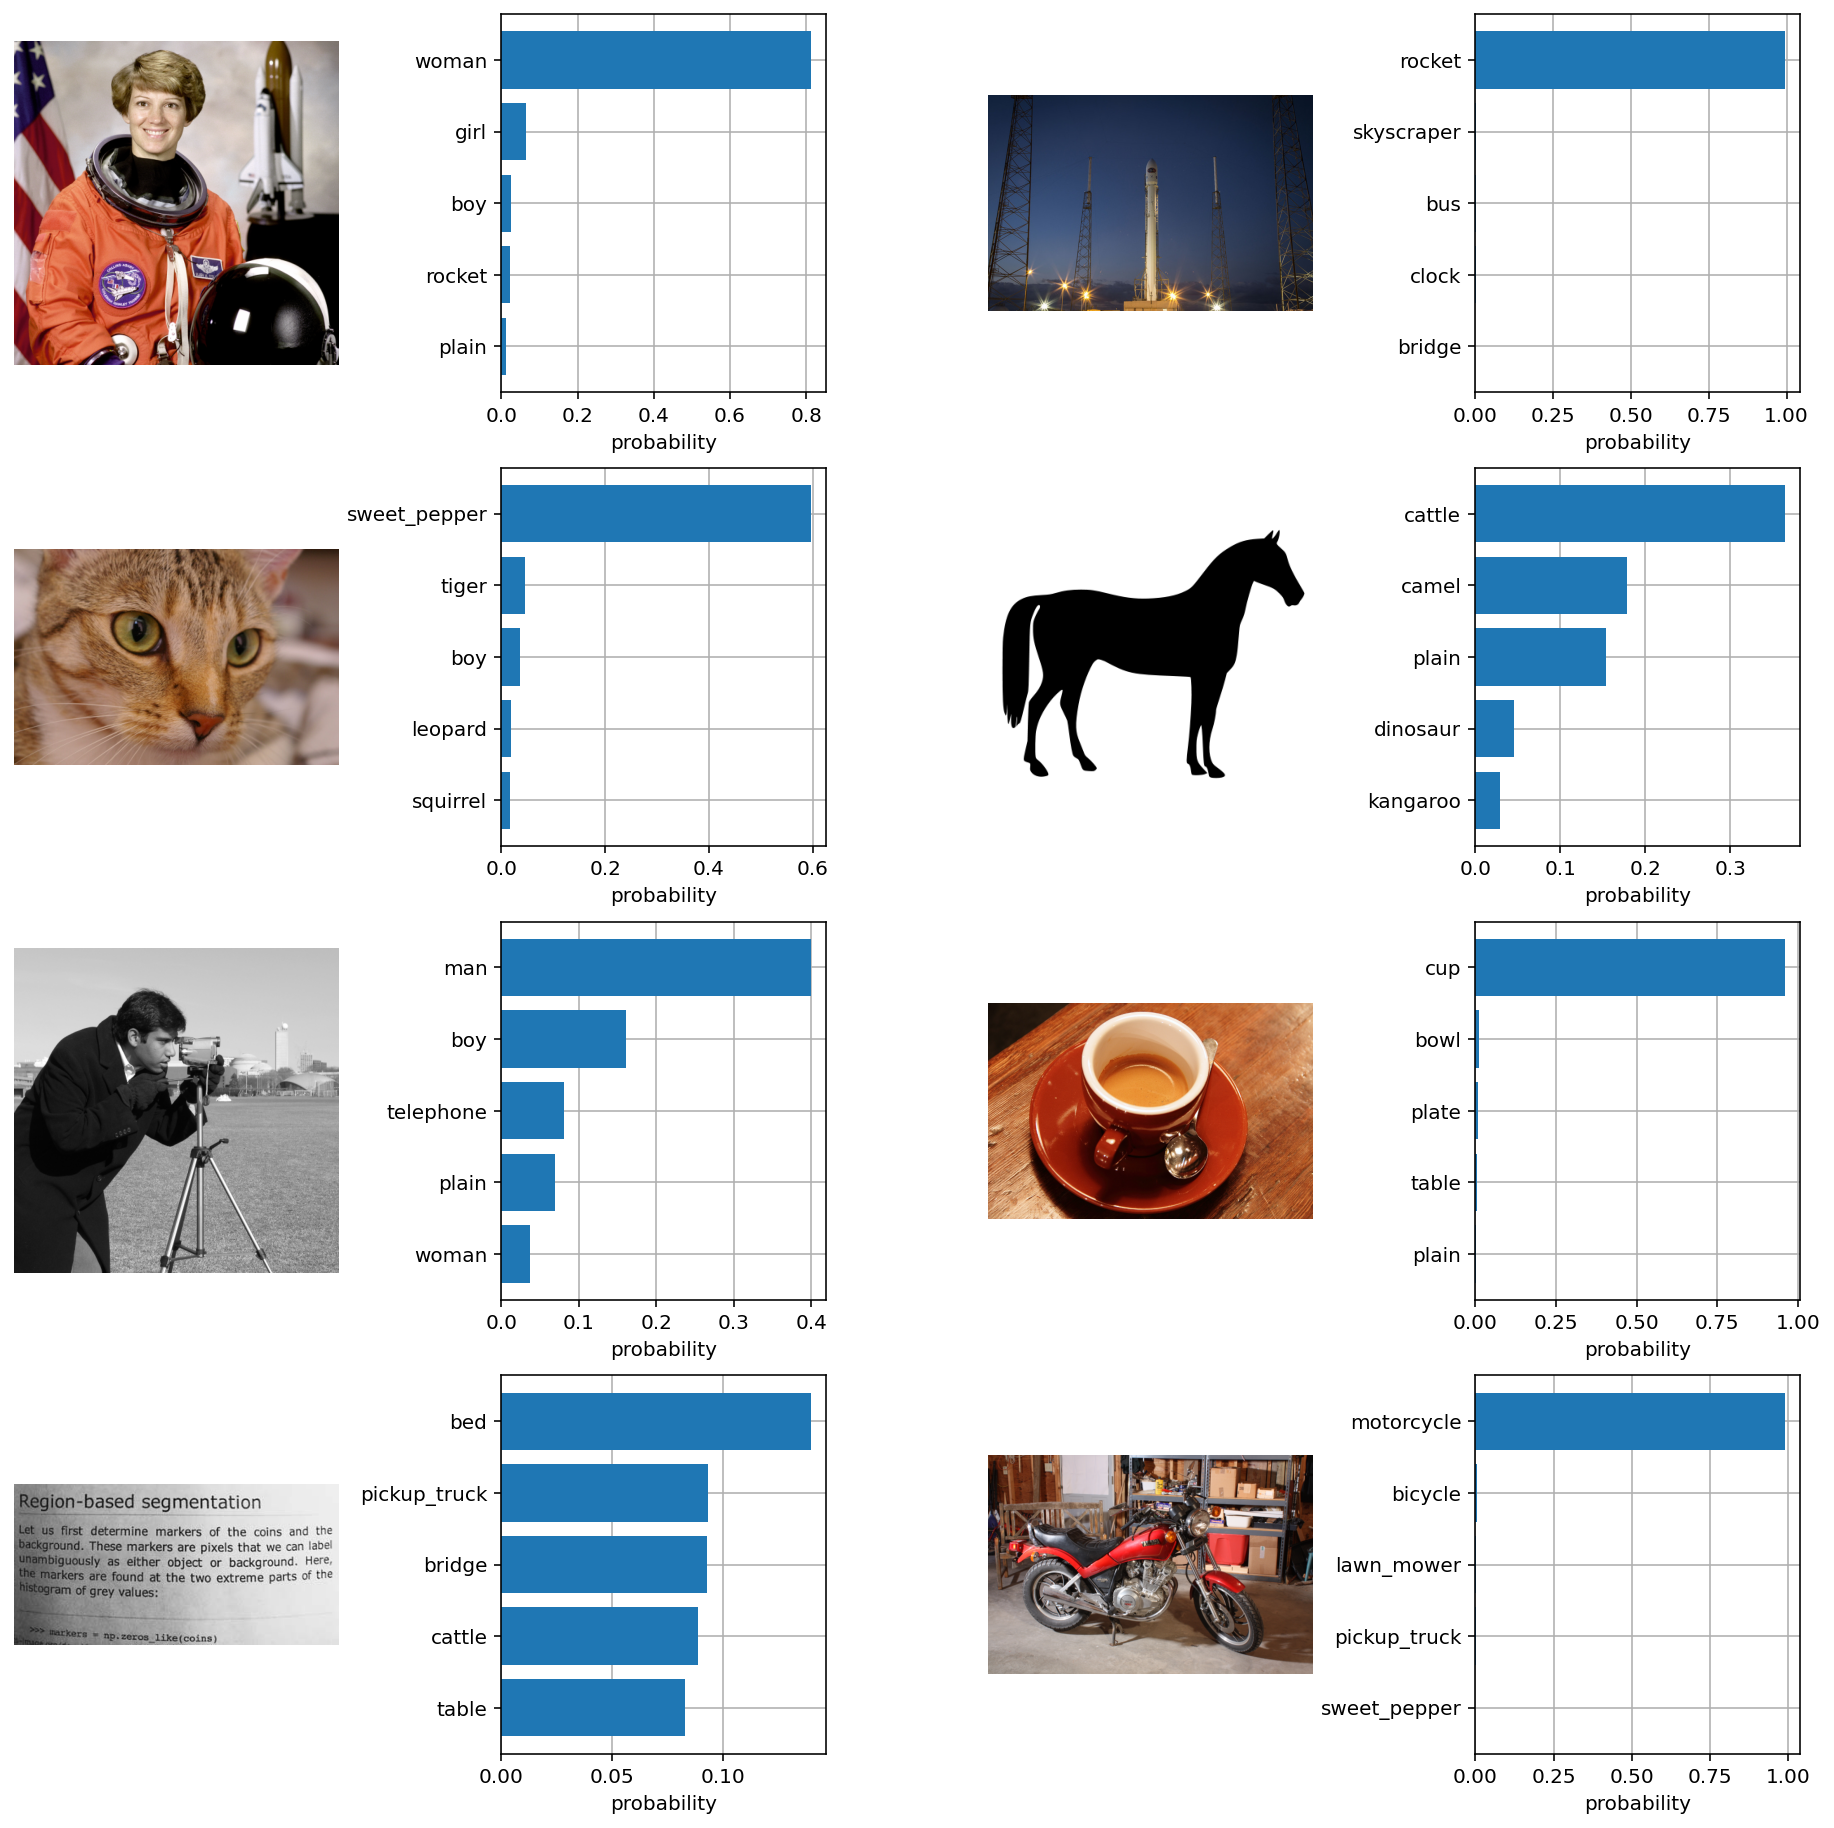

In [16]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)

plt.show()

# Uploading Your Own Image

> If you're not using Chrome or Firefox already (or anything other than Safari), now would be a good time to switch over as the next cell will give you a `RangeError` in Safari.

In [17]:
from pathlib import Path
from PIL import Image, ImageDraw
import imageio
try:
  from google.colab import files
except ImportError:
  pass

uploaded_images_path = Path('uploaded_images')

In [18]:
if not uploaded_images_path.exists():
    uploaded_images_path.mkdir()

def upload_image():
  uploaded = files.upload()
  name = list(uploaded.keys())[0]
  b64 = uploaded[name]
  img = imageio.imread(b64)
  img = imageio.imwrite(uploaded_images_path/name, img)
  image = Image.open(os.path.join(uploaded_images_path, name)).convert("RGB")
  processed_image = preprocess(image)

  return image, processed_image

# Must be a .jpg or .png!!
image, processed_image = upload_image()

Saving man_in_treehouse.jpg to man_in_treehouse.jpg


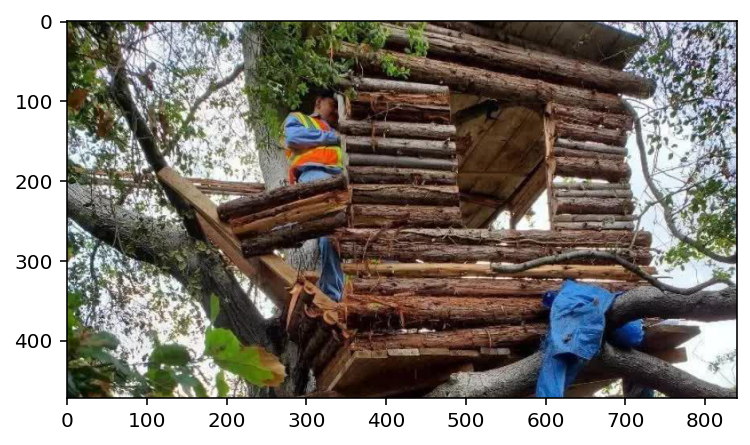

In [19]:
plt.imshow(image)

In it's basic form, CLIP takes an image and then a sequence of possible text based options. So fill the array below with a bunch of _possible_ solutions for CLIP to pair with your image. They could make no sense at all... Feel free to edit the caption below too (`"This is a photo of a man in a..."`).

In [20]:
options = ["treehouse", "tree", "bush", "house", "bedroom", "car", "unicorn"]
text_descriptions = [f"This is a photo of a man in a {label}" for label in options]
text_tokens = clip.tokenize(text_descriptions).cuda()
image_input = torch.tensor(processed_image).unsqueeze(0).cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [21]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

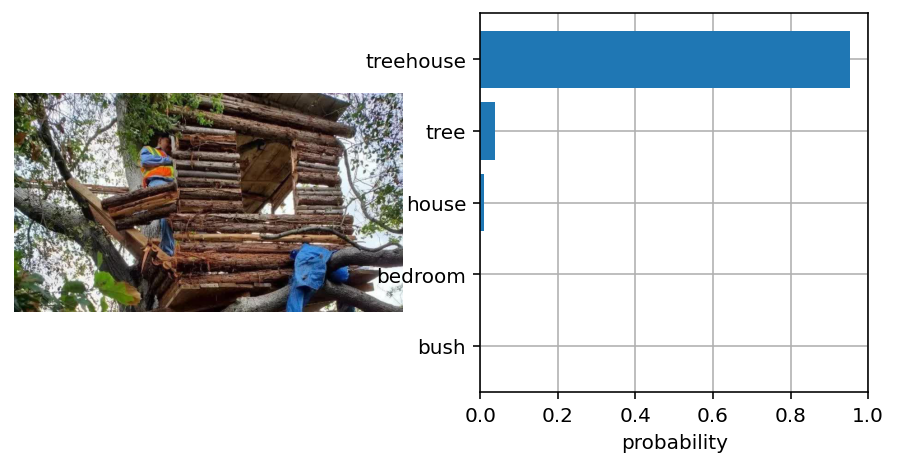

In [22]:
plt.figure(figsize=(16, 16))

plt.subplot(4, 4, 2)
plt.imshow(image)
plt.axis("off")

plt.subplot(4, 4, 3)
y = np.arange(top_probs.shape[-1])
plt.grid()
plt.barh(y, top_probs[0])
plt.gca().invert_yaxis()
plt.gca().set_axisbelow(True)
plt.yticks(y, [options[index] for index in top_labels[0].numpy()])
plt.xlabel("probability")


plt.show()

In [ ]:
|